In [2]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [3]:
tf.reset_default_graph()

In [4]:
!pip install cleverhans

In [5]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Activation,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalMaxPooling2D
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.attacks import FastGradientMethod, MadryEtAl, DeepFool, CarliniWagnerL2

In [7]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY
 
 # scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm


In [9]:
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    # tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(tpu=TPU_WORKER)))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)  
    # tpu_model.compile(optimizer=opt, 
    #                   loss='sparse_categorical_crossentropy',
    #                   metrics=['accuracy'])
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
# run the test harness for evaluating a model
# def run_test_harness():
# load dataset
#tf.reset_default_graph()
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# define model
model = define_model()
#model = tf.contrib.tpu.keras_to_tpu_model(model,strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(trainX, trainY, batch_size=64)
# fit model


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
steps = int(trainX.shape[0] / 64)
history  = model.fit_generator(it_train, steps_per_epoch=steps, epochs=200, validation_data=(testX, testY))


Epoch 1/200
781/781 [==============================] - 49s 63ms/step - loss: 2.1171 - accuracy: 0.2980 - val_loss: 1.5383 - val_accuracy: 0.4375
Epoch 2/200
781/781 [==============================] - 42s 54ms/step - loss: 1.6316 - accuracy: 0.4066 - val_loss: 1.5257 - val_accuracy: 0.4394
Epoch 3/200
781/781 [==============================] - 42s 54ms/step - loss: 1.4938 - accuracy: 0.4558 - val_loss: 1.3941 - val_accuracy: 0.4969
Epoch 4/200
781/781 [==============================] - 42s 54ms/step - loss: 1.4161 - accuracy: 0.4836 - val_loss: 1.4688 - val_accuracy: 0.4748
Epoch 5/200
781/781 [==============================] - 42s 54ms/step - loss: 1.3463 - accuracy: 0.5081 - val_loss: 1.4007 - val_accuracy: 0.5019
Epoch 6/200
781/781 [==============================] - 42s 54ms/step - loss: 1.2958 - accuracy: 0.5330 - val_loss: 1.3083 - val_accuracy: 0.5388
Epoch 7/200
781/781 [==============================] - 41s 53ms/step - loss: 1.2536 - accuracy: 0.5484 - val_loss: 1.2587 - val_a

In [ ]:

model.save('./drive/My Drive/model_store/crf10best.hdf5')
# evaluate model
_, acc = model.evaluate(testX, testY)
print('> %.3f' % (acc * 100.0))

10000/10000 [==============================] - 3s 265us/step
> 86.580


In [11]:
model = keras.models.load_model('./drive/My Drive/model_store/crf10best.hdf5')

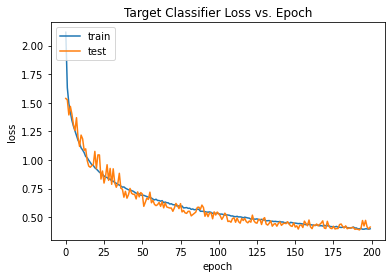

In [12]:
#Plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Target Classifier Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

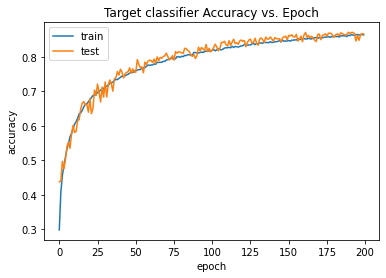

In [13]:
#Plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Target classifier Accuracy vs. Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
#Print accuracy of classifier on MNIST testing data
scores = model.evaluate(testX, testY)
print("Classifier Accuracy: %.2f%%" %(scores[1]*100))

10000/10000 [==============================] - 8s 817us/step
Classifier Accuracy: 86.58%


In [13]:
# Run this block as-is without modifying 
from keras import backend
#Get TensorFlow Session to pass into Cleverhans modules
sess = backend.get_session()

#Create wrapper for classifier model so that it can be passed into Cleverhans modules
wrap = KerasModelWrapper(model)

In [14]:
#Implementing the FGM attack

#FGM Instance on trained classifier from Part 1
fgm = FastGradientMethod(wrap, sess=sess)

#Attack parameters
fgm_params = {'eps':0.1, 'clip_min': 0., 'clip_max': 1.}

#Generate adversarial dataz
fgm_attack_data = np.zeros([10000,32,32,3])
for i in range(2):
  print(i)
  fgm_attack_data[i*5000:(i+1)*5000] = fgm.generate_np(testX[i*5000:(i+1)*5000], **fgm_params)

#Evaluate accuracy on target classifier 
fgm_adv_scores = model.evaluate(fgm_attack_data, testY)
print("FGM Adversarial Attak Accuracy: %.2f%%" %(fgm_adv_scores[1]*100))



[INFO 2020-07-04 03:25:58,056 cleverhans] Constructing new graph for attack FastGradientMethod


0

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
dim is deprecated, use axis instead
1
10000/10000 [==============================] - 1s 115us/step
FGM Adversarial Attak Accuracy: 8.22%


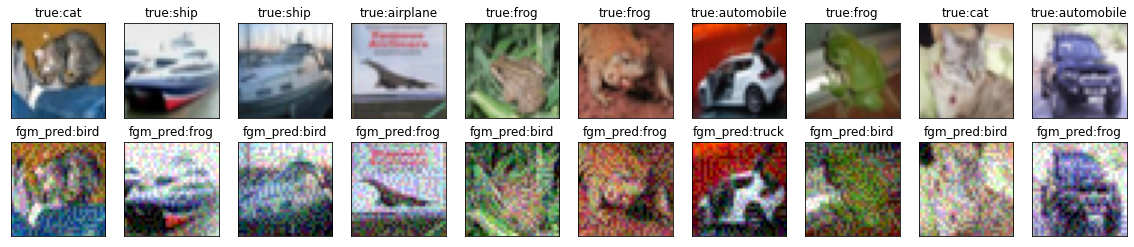

In [15]:
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#Show ten original samples and their corresponding adversarial samples
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original samples 
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(testX[i])
    plt.imshow(testX[i])
    p=model.predict(np.array(testX[i]).reshape(1,32,32,3))    #绘制预测标签
    label = labels[np.argsort(p[0])[::-1][0]]
    true_label = labels[np.argsort(testY[i])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('true:'+str(true_label))

    # display FGM asversarial sample 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(fgm_attack_data[i])
    p = model.predict(np.array(fgm_attack_data[i]).reshape(1,32,32,3))    #绘制预测标签
    label = labels[np.argsort(p[0])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('fgm_pred:'+str(label))
plt.show()

In [15]:
#Implementing the PGD attack

#Maximum allowed perturbation
pgd_eps = 0.1

#PGD Instance on trained classifier from Part 1
pgd = MadryEtAl(wrap, sess=sess)

#Attack parameters
pgd_params = {'eps':pgd_eps, 'eps_iter':0.01, 'nb_iter':20, 'clip_min': 0., 'clip_max': 1.}

#Generate adversarial data
pgd_attack_data = np.zeros([10000,32,32,3])
for i in range(2):
  print(i)
  pgd_attack_data[i*5000:(i+1)*5000] = pgd.generate_np(testX[i*5000:(i+1)*5000], **pgd_params)

#Evaluate accuracy on target classifier
pgd_scores = model.evaluate(pgd_attack_data, testY)
print("PGD Adversarial Attack Accuracy: %.2f%%" %(pgd_scores[1]*100))

[INFO 2020-07-04 03:26:15,147 cleverhans] Constructing new graph for attack MadryEtAl


0

1
10000/10000 [==============================] - 1s 116us/step
PGD Adversarial Attack Accuracy: 2.38%


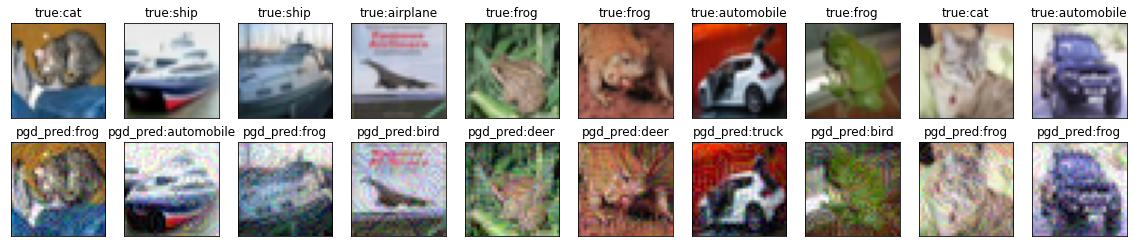

In [17]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original samples 
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(testX[i])
    plt.imshow(testX[i])
    p=model.predict(np.array(testX[i]).reshape(1,32,32,3))    #绘制预测标签
    label = labels[np.argsort(p[0])[::-1][0]]
    true_label = labels[np.argsort(testY[i])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('true:'+str(true_label))

    # display FGM asversarial sample 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(pgd_attack_data[i])
    p = model.predict(np.array(pgd_attack_data[i]).reshape(1,32,32,3))    #绘制预测标签
    label = labels[np.argsort(p[0])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('pgd_pred:'+str(label))
plt.show()

In [16]:
#Implementing the CW attack

#CW Instance on trained classifier from Part 1
cw = CarliniWagnerL2(wrap, sess=sess)

#Attack parameters
cw_params = {'binary_search_steps': 1,
           'y': None,
           'max_iterations': 200,
           'learning_rate': 0.1,
           'batch_size': 16,
           'initial_const': 1,
           'clip_min':0.0,
           'clip_max':1.0}


#Generate adversarial data
cw_attack_data = cw.generate_np(testX, **cw_params)

#Evaluate accuracy on target classifier
cw_scores = model.evaluate(cw_attack_data, testY)
print("Carlini & Wagner Adversarial Attack Accuracy: %.2f%%" %(cw_scores[1]*100))

[INFO 2020-07-04 03:27:03,480 cleverhans] Constructing new graph for attack CarliniWagnerL2



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
10000/10000 [==============================] - 1s 109us/step
Carlini & Wagner Adversarial Attack Accuracy: 5.39%


In [17]:
#Implementing the DeepFool attack

#DeepFool instance on trained classifier from Part 1
deepfool = DeepFool(wrap, sess=sess)

#Attack parameters
df_params = {'nb_candidate': 10, 'max_iter': 50, 'clip_min': 0., 'clip_max': 1.}

#Generate adversarial data
df_attack_data = np.zeros([10000,32,32,3])
for i in range(10):
  print(i)
  df_attack_data[i*1000:(i+1)*1000] = deepfool.generate_np(testX[i*1000:(i+1)*1000], **df_params)

#Evaluate accuracy on target classifier
df_scores = model.evaluate(df_attack_data, testY)
print("DeepFool Adversarial Attack Accuracy: %.2f%%" %(df_scores[1]*100))

[INFO 2020-07-04 03:29:48,424 cleverhans] Constructing new graph for attack DeepFool


0


[INFO 2020-07-04 03:29:59,353 cleverhans] Attack result at iteration 5 is [6 1 1 0 4 5 9 4 6 9 4 1 6 5 8 6 7 6 0 2 9 2 6 1 5 3 5 6 1 4 3 6 4 6 0 1 7
 9 0 8 2 2 5 8 9 0 6 9 4 2 6 6 7 6 0 0 3 7 4 5 4 6 8 1 3 6 8 6 3 3 5 3 0 0
 9 4 0 1 7 8 0 9 9 4 5 9 2 8 0 1 8 6 9 3 2 3 4 4 0 4 7 4 1 3 9 1 2 3 8 3 7
 8 2 6 8 6 4 9 2 4 0 4 9 4 1 2 2 3 3 2 2 9 9 9 6 3 1 9 6 1 3 2 3 9 6 7 6 5
 3 5 0 1 3 9 2 6 5 3 3 0 0 0 5 4 8 2 4 4 9 8 6 6 8 8 1 1 6 4 2 8 4 3 0 6 6
 0 5 2 3 8 6 3 7 9 6 7 6 9 7 2 6 0 8 9 9 5 8 6 5 8 6 0 0 8 1 0 5 1 8 7 4 5
 1 3 3 1 1 6 7 2 3 1 6 1 9 4 6 9 3 3 8 9 1 0 4 3 9 9 4 0 7 5 1 1 4 8 6 8 0
 1 9 9 3 6 0 2 3 6 4 2 4 5 1 5 9 6 1 2 6 7 9 0 2 9 0 1 8 0 0 8 6 4 4 1 8 2
 8 8 2 2 6 4 5 2 2 8 9 6 9 4 1 3 8 2 7 3 2 4 5 3 2 3 6 2 7 6 4 3 2 2 9 1 3
 6 2 1 6 3 2 0 4 1 0 7 0 3 7 1 0 0 1 6 0 2 6 2 6 3 1 4 1 3 0 0 0 0 9 6 8 9
 2 2 8 3 7 0 0 9 4 4 2 1 6 9 2 8 4 2 5 7 6 8 2 6 1 4 3 6 9 9 9 1 0 0 0 2 8
 9 0 3 5 0 0 8 9 0 6 7 3 6 2 7 0 3 4 8 3 4 6 6 4 8 6 2 7 2 6 6 5 9 9 6 0 8
 3 2 8 0 4 2 5 8 4 4 8 5 3

1


[INFO 2020-07-04 03:30:09,487 cleverhans] Attack result at iteration 5 is [5 8 9 5 0 9 8 0 8 8 0 0 0 1 6 6 9 3 0 7 9 0 8 9 6 3 6 7 2 4 5 3 2 8 3 6 6
 9 0 7 5 7 2 4 8 3 0 8 9 4 3 2 0 5 9 2 3 9 1 0 1 9 7 6 1 2 1 4 0 3 5 1 1 2
 2 1 8 0 0 5 6 3 1 5 3 7 7 3 3 3 8 8 3 4 3 6 5 9 9 6 9 1 0 8 9 2 1 1 1 1 2
 0 5 0 8 9 3 3 4 0 5 2 0 5 3 3 2 0 5 5 4 8 3 6 9 3 1 8 7 9 3 9 9 6 0 3 4 6
 6 4 4 6 1 9 2 1 1 3 9 9 1 6 4 7 8 8 5 8 0 4 5 0 7 8 1 1 0 9 2 7 5 3 8 4 3
 9 7 9 6 2 9 9 1 7 7 2 4 0 4 1 3 4 4 8 4 0 9 0 9 0 2 2 9 0 1 5 8 5 0 5 6 8
 9 0 4 4 2 5 3 8 6 1 9 7 1 2 2 8 9 3 6 8 6 3 3 2 5 3 2 6 2 9 9 1 0 0 9 6 9
 0 9 0 0 0 0 9 8 2 0 5 1 9 4 3 4 7 6 2 0 1 5 1 1 1 1 1 0 8 9 9 7 1 4 7 0 8
 4 2 1 0 3 9 2 6 8 8 8 0 4 2 8 0 4 9 1 4 3 1 2 2 2 6 1 9 6 2 4 6 3 7 0 1 9
 2 4 9 6 2 3 3 8 0 4 8 1 2 9 0 6 0 3 7 7 3 9 5 6 8 0 0 5 8 2 8 2 2 0 0 5 0
 1 8 1 4 0 7 0 0 9 1 4 1 0 6 1 3 8 9 3 6 3 3 5 2 2 3 9 0 8 2 3 6 6 2 8 0 0
 0 9 8 0 4 9 6 8 5 5 0 6 0 7 2 1 2 1 3 4 8 5 6 9 6 0 4 2 6 6 8 2 9 8 2 3 4
 7 3 2 0 2 4 5 6 3 2 5 9 4

2


[INFO 2020-07-04 03:30:19,641 cleverhans] Attack result at iteration 5 is [6 2 4 3 7 3 4 0 0 9 2 4 3 9 0 6 4 3 3 6 8 0 3 5 2 2 3 1 2 6 6 9 2 2 6 0 2
 6 5 1 1 4 9 0 3 9 5 3 0 4 0 3 8 4 5 7 7 6 8 8 3 4 4 9 1 4 4 4 6 2 6 1 6 6
 2 2 5 2 1 2 9 3 8 3 4 2 0 4 4 7 7 6 6 2 3 0 1 6 2 8 4 3 2 9 2 2 3 6 4 8 3
 1 8 2 3 7 8 0 0 2 1 0 9 6 3 9 1 2 4 9 2 9 6 9 5 2 9 6 4 8 9 5 0 1 5 4 2 0
 1 2 8 0 4 0 3 8 8 3 1 7 8 5 7 6 6 7 2 5 6 0 6 5 4 6 9 9 9 1 7 1 3 0 6 2 0
 9 1 5 9 0 1 6 8 2 9 6 0 6 0 5 0 3 0 2 0 3 9 6 2 3 0 4 6 2 6 7 5 2 6 5 9 0
 4 0 9 0 2 0 5 7 4 5 3 5 4 6 0 2 9 4 1 2 4 7 1 0 1 2 0 1 3 5 6 2 0 8 6 4 6
 7 7 6 8 3 2 8 0 3 6 6 4 9 5 6 9 4 8 6 9 1 0 3 1 6 0 6 3 5 2 9 1 7 6 8 9 8
 8 4 2 3 0 6 4 5 3 0 5 5 9 3 7 4 6 7 0 0 5 2 0 0 3 3 2 0 2 7 5 0 4 6 8 7 2
 9 9 2 6 5 2 5 9 2 6 4 7 1 6 9 0 5 1 9 6 6 8 1 6 0 3 7 5 2 6 1 4 6 0 2 2 9
 8 8 2 8 9 8 0 4 9 0 0 2 1 4 7 7 2 8 9 3 9 5 2 9 4 5 7 5 0 0 0 8 0 0 2 6 5
 8 6 2 0 8 2 4 5 4 2 4 0 6 1 0 7 6 0 9 2 5 6 2 4 6 0 1 8 4 2 9 8 9 0 4 3 0
 6 4 1 8 5 3 9 8 4 3 6 3 8

3


[INFO 2020-07-04 03:30:29,806 cleverhans] Attack result at iteration 5 is [9 9 0 2 2 7 7 4 9 4 2 6 8 3 3 2 2 3 4 3 8 9 0 5 4 2 5 8 9 9 2 5 4 9 3 6 0
 2 5 9 4 6 3 6 4 7 9 3 2 5 2 2 6 3 0 4 6 3 6 0 4 8 8 2 9 7 1 4 2 8 9 3 8 5
 9 6 0 9 0 6 8 0 3 0 6 6 1 8 2 8 7 9 7 4 2 6 0 7 5 1 2 7 8 0 5 0 0 7 4 9 7
 8 8 6 8 3 4 0 2 6 2 0 9 9 8 0 8 6 1 5 5 4 3 7 9 7 6 3 2 6 0 0 6 6 8 1 6 0
 8 9 1 1 9 6 9 0 8 9 0 6 2 0 9 3 2 9 1 3 8 3 1 0 8 1 6 9 4 2 4 9 3 9 1 5 8
 6 2 4 3 9 5 8 2 4 3 6 6 3 6 3 7 3 5 2 6 2 8 7 8 5 1 8 2 1 3 9 4 4 1 8 9 3
 7 4 2 1 0 4 8 1 4 3 2 4 7 3 6 1 2 9 4 5 4 0 5 0 8 4 2 4 8 3 5 9 9 7 2 9 7
 5 0 7 0 5 0 0 0 5 7 4 0 6 4 2 9 0 7 4 2 0 0 0 1 7 7 9 3 7 0 1 7 3 2 8 2 1
 3 3 4 2 6 8 8 8 0 0 4 1 9 0 2 6 8 6 9 5 2 4 9 0 7 0 5 3 3 8 2 4 0 3 7 0 4
 4 6 9 8 5 2 3 2 9 0 5 9 5 2 9 9 2 0 9 3 7 3 5 2 6 1 7 6 7 8 6 5 1 8 9 0 5
 1 5 6 2 6 6 3 9 7 3 0 3 6 0 9 0 0 3 3 9 3 4 9 6 6 8 2 8 0 8 0 7 6 0 6 4 8
 9 4 1 7 3 4 8 7 6 6 0 9 2 3 9 3 4 4 4 9 3 8 2 0 6 3 7 7 3 2 4 1 0 2 8 0 4
 2 2 3 6 2 9 9 2 2 0 0 5 6

4


[INFO 2020-07-04 03:30:41,451 cleverhans] Attack result at iteration 5 is [0 6 7 2 4 3 0 1 0 0 2 8 7 3 1 1 3 4 1 4 0 7 3 5 3 8 1 6 8 2 9 6 5 4 0 5 1
 2 9 3 8 4 0 6 2 1 4 6 2 2 0 5 6 6 8 1 9 4 3 0 1 8 8 4 4 6 2 9 1 3 1 2 5 2
 2 6 4 5 2 2 8 9 8 9 0 6 8 3 7 2 6 9 4 4 7 0 0 7 0 6 5 0 2 0 4 4 8 4 6 3 6
 2 7 6 2 9 6 2 2 8 0 6 4 0 8 8 4 2 1 9 6 8 1 5 9 8 0 4 6 8 9 0 0 5 8 0 4 2
 6 1 3 4 6 0 0 6 8 9 2 5 3 2 8 2 6 9 8 1 1 3 9 8 3 0 0 8 5 3 2 2 8 0 7 4 6
 4 5 4 4 8 5 8 9 9 8 3 0 6 9 0 2 9 7 6 2 6 9 8 7 7 3 7 9 7 7 1 2 2 0 8 3 0
 3 0 4 6 8 6 8 8 2 0 3 1 6 5 9 6 5 6 4 2 0 3 2 9 2 5 5 3 6 8 1 1 9 6 4 1 0
 7 9 8 6 5 4 1 5 0 3 8 4 9 4 7 6 2 9 4 6 6 0 2 6 2 1 6 0 3 9 9 5 6 1 1 0 8
 1 1 1 8 0 4 2 3 2 1 8 6 4 5 7 4 5 2 9 0 8 0 9 6 0 3 7 3 1 2 6 1 0 4 8 3 4
 9 3 1 9 9 9 4 4 9 6 7 7 2 9 0 1 8 7 0 5 4 6 3 8 2 7 6 1 9 6 0 1 1 2 1 3 7
 0 9 9 8 2 3 2 2 9 9 1 4 2 7 8 0 0 2 2 0 2 9 3 9 3 2 9 0 2 6 5 9 2 0 6 8 6
 6 0 8 6 5 4 4 6 3 2 7 1 4 3 2 1 6 9 9 8 4 0 5 8 8 5 2 0 5 6 3 4 6 6 9 1 7
 0 1 1 0 6 1 1 0 3 0 2 0 4

5


[INFO 2020-07-04 03:30:50,164 cleverhans] Attack result at iteration 5 is [6 4 0 4 2 7 7 6 2 4 3 4 3 3 4 3 3 9 7 0 9 8 3 6 9 7 2 2 1 6 0 0 0 5 0 3 4
 1 0 4 1 1 6 9 6 0 6 3 8 4 5 9 2 5 0 0 9 6 8 2 2 6 6 1 7 8 6 9 7 8 7 9 2 9
 3 3 3 2 0 9 5 6 5 1 5 6 4 0 3 3 9 9 1 8 1 0 0 7 4 6 6 4 2 6 9 0 2 8 9 8 2
 0 2 4 0 3 5 4 2 0 0 3 5 6 9 9 1 9 4 2 3 2 9 6 5 9 1 8 0 8 0 2 0 7 0 2 8 1
 5 6 6 6 3 9 2 5 8 2 7 2 1 5 2 3 8 3 7 5 4 6 1 2 4 8 2 3 7 4 2 3 7 1 9 5 0
 9 3 2 9 2 4 5 9 3 2 7 6 5 8 9 3 0 0 6 6 0 6 1 2 4 8 7 2 9 9 2 3 9 4 4 7 9
 3 2 3 8 9 2 4 5 1 3 2 1 9 1 8 2 2 3 9 4 8 1 4 1 2 4 0 0 5 7 7 7 1 2 8 4 2
 8 2 6 0 8 4 6 2 2 6 6 1 3 9 5 6 4 8 9 2 9 7 3 7 7 6 1 2 3 6 4 7 2 4 3 0 8
 2 4 3 4 1 5 2 3 8 6 6 9 1 3 0 1 6 9 6 9 3 7 0 0 0 9 7 8 2 0 6 8 1 2 7 4 1
 1 3 0 6 4 1 8 2 3 9 5 6 7 4 9 1 6 1 2 5 1 8 0 4 8 9 2 7 0 4 4 9 9 1 0 6 2
 3 5 8 1 8 8 3 3 9 0 9 5 8 6 2 5 8 2 5 6 9 1 9 2 8 8 8 8 8 3 0 0 5 4 2 0 4
 4 0 9 5 6 4 5 2 7 9 3 2 6 2 3 8 4 2 2 5 6 2 2 4 1 9 2 3 0 3 9 4 9 0 3 2 4
 0 4 6 9 1 1 2 4 9 9 0 6 8

6


[INFO 2020-07-04 03:31:01,102 cleverhans] Attack result at iteration 5 is [4 9 2 0 4 6 2 3 0 4 1 4 6 4 4 8 2 1 6 6 4 0 9 5 4 1 5 6 8 2 1 3 6 4 1 3 8
 3 9 1 5 8 2 9 4 9 2 8 5 8 4 5 0 2 5 8 6 1 9 0 2 8 5 4 2 7 6 2 6 8 8 4 3 3
 4 6 5 0 5 0 9 2 8 7 9 2 9 6 6 4 9 2 6 2 7 1 0 4 2 5 9 0 3 8 9 8 0 8 7 6 9
 2 8 1 0 0 5 8 4 0 8 5 3 6 0 0 5 2 2 0 8 6 5 2 8 4 8 4 3 1 8 0 5 1 7 2 0 0
 2 5 9 3 3 4 0 0 3 9 6 1 9 4 0 6 4 5 8 1 7 4 0 2 2 1 5 5 7 7 4 1 8 1 8 3 8
 3 0 0 1 0 4 2 2 8 2 6 6 4 9 3 8 3 6 2 2 9 5 0 1 4 4 0 6 2 5 4 7 1 6 4 6 8
 2 4 2 6 3 2 4 3 6 0 6 4 7 2 9 5 0 3 0 8 0 4 6 5 7 8 2 3 3 1 6 6 3 5 0 3 8
 2 8 6 4 4 4 6 5 1 3 0 2 2 6 8 1 0 4 6 3 9 9 7 2 6 7 0 7 6 3 1 8 1 2 5 8 2
 1 3 4 2 8 9 1 0 0 3 9 7 3 4 3 6 6 4 2 6 9 0 4 0 4 1 7 9 4 7 0 2 8 8 1 2 7
 6 2 6 7 0 5 3 6 6 0 9 2 5 0 8 8 6 0 8 5 2 1 8 9 4 0 0 6 8 4 0 3 4 0 2 5 1
 2 9 9 1 9 4 0 1 7 1 6 9 7 5 6 3 5 4 5 2 0 7 2 3 8 0 6 3 4 9 8 4 6 3 0 9 9
 5 8 9 1 2 8 4 9 9 4 9 4 1 5 4 2 5 0 1 9 2 5 6 1 0 0 2 0 8 0 4 2 2 9 6 7 2
 0 9 3 6 5 0 0 8 4 0 6 6 6

7


[INFO 2020-07-04 03:31:09,077 cleverhans] Attack result at iteration 5 is [2 9 3 6 5 8 3 1 9 2 0 5 5 9 2 1 5 9 8 5 9 9 4 0 1 2 6 6 1 7 4 8 6 0 9 1 2
 5 8 6 2 4 0 4 6 6 1 0 0 0 0 5 9 9 0 0 3 2 1 2 8 7 4 6 8 5 3 7 2 9 4 8 0 1
 5 1 0 2 4 2 7 6 8 3 6 3 4 5 0 3 4 3 6 4 3 2 2 7 5 2 7 2 2 8 2 0 0 3 7 2 6
 7 8 1 9 1 2 1 7 2 5 1 1 3 2 3 0 2 3 9 3 1 6 9 4 2 8 2 8 8 2 3 0 3 2 3 7 2
 9 6 8 9 3 0 0 8 9 3 5 2 6 3 3 6 8 2 9 4 9 9 7 0 2 6 3 7 3 0 8 1 3 2 0 6 6
 0 0 7 7 8 6 0 5 0 0 2 0 4 7 9 0 2 3 9 5 3 5 3 8 2 6 6 8 2 3 9 4 0 9 4 7 5
 6 4 7 8 9 4 6 6 6 0 1 3 1 2 9 4 2 0 4 5 4 9 3 2 2 0 2 1 9 4 3 2 3 3 6 6 2
 2 9 0 6 7 6 3 5 5 6 4 1 4 0 0 1 2 6 6 2 3 9 2 8 3 9 9 6 3 4 0 1 0 1 5 2 6
 0 7 2 2 5 4 3 0 7 2 7 9 2 6 7 8 5 4 3 2 8 3 4 0 0 0 6 6 8 3 6 6 2 0 2 9 9
 2 3 4 4 2 3 6 0 6 5 7 6 6 2 8 6 5 1 2 6 0 4 6 2 8 0 6 5 0 1 9 6 6 5 3 7 8
 3 3 3 2 7 7 9 6 5 5 4 6 8 7 7 1 3 0 2 7 8 2 9 5 9 6 0 6 5 5 3 3 0 3 0 0 3
 1 6 0 6 3 0 6 0 5 8 6 6 2 5 2 7 2 0 6 4 6 0 7 6 9 4 3 8 9 0 5 3 4 3 9 1 5
 9 5 1 2 1 6 1 1 7 7 8 9 9

8


[INFO 2020-07-04 03:31:20,743 cleverhans] Attack result at iteration 5 is [1 8 4 5 3 9 7 7 8 3 0 3 6 0 2 0 3 2 2 6 4 9 7 5 0 3 0 7 9 5 0 0 9 5 1 9 6
 8 8 1 4 6 4 2 0 3 8 8 8 9 4 1 4 9 1 4 9 1 4 6 3 4 4 8 8 0 5 1 8 0 2 4 6 8
 3 0 5 5 4 5 6 4 3 3 3 0 0 7 4 0 2 0 0 4 1 8 4 8 6 6 2 8 7 1 0 8 8 8 3 6 3
 5 6 4 6 5 0 0 8 8 0 1 3 9 4 1 0 1 3 6 3 2 6 9 2 2 2 0 8 9 6 6 4 8 1 1 1 7
 1 1 3 8 1 6 1 8 2 5 1 1 3 5 1 0 4 9 2 3 9 7 6 2 2 5 5 6 8 8 1 2 4 5 9 5 4
 8 0 2 0 0 4 2 3 5 9 8 3 8 2 7 0 6 5 5 6 4 0 5 9 2 8 9 8 3 9 9 5 1 6 3 8 9
 8 0 3 0 8 9 8 1 6 9 5 6 1 4 6 4 9 8 4 0 4 7 7 5 2 9 0 8 2 6 6 0 0 1 0 9 8
 0 9 8 2 7 0 8 3 2 2 6 4 5 1 4 3 5 9 2 0 5 3 5 0 9 0 8 7 1 8 7 0 4 1 6 0 3
 5 9 5 6 6 3 6 0 1 6 2 0 5 6 3 8 9 4 0 4 6 3 5 5 0 4 6 0 5 8 4 8 0 0 2 3 0
 7 4 4 6 6 3 0 3 5 0 6 2 7 5 9 5 2 0 0 5 4 7 1 9 0 2 6 7 8 5 5 7 9 1 4 0 6
 2 3 5 0 4 4 4 8 5 8 9 4 8 0 3 9 2 8 9 0 9 9 3 8 8 8 3 2 4 7 1 3 8 2 4 2 1
 0 8 3 3 0 2 0 2 1 2 9 2 2 3 6 3 2 6 2 0 8 2 0 1 2 7 3 0 9 7 4 0 8 2 9 6 4
 6 0 6 4 3 2 9 2 4 8 0 1 7

9


[INFO 2020-07-04 03:31:30,236 cleverhans] Attack result at iteration 5 is [3 8 4 4 7 5 8 1 8 2 0 6 1 4 3 0 8 2 0 8 3 0 6 0 8 6 1 3 0 9 0 8 1 2 4 4 7
 1 6 3 2 3 6 8 0 0 9 7 9 2 3 0 0 7 0 2 5 1 7 3 1 4 1 2 9 3 8 9 8 1 0 3 1 4
 2 2 4 6 6 8 5 4 3 0 3 1 7 5 2 6 6 4 2 5 6 7 7 9 8 1 1 0 4 4 3 0 4 7 4 4 9
 3 7 6 9 1 8 1 3 7 4 5 1 5 0 8 0 1 3 2 2 5 2 8 7 3 2 0 7 8 1 6 5 0 9 1 3 3
 3 0 4 2 3 0 0 3 2 5 0 1 3 4 0 6 3 2 9 2 2 0 0 8 7 0 2 0 2 1 9 1 7 4 8 0 4
 8 2 6 2 0 5 6 4 2 3 3 4 9 6 9 4 6 4 0 9 7 0 1 2 1 3 8 3 7 7 3 2 9 4 0 0 3
 9 9 4 8 4 1 5 8 2 7 9 1 6 8 1 5 8 0 0 4 0 5 4 7 0 9 8 8 5 3 6 9 4 4 8 3 1
 4 3 3 2 3 3 8 0 6 4 6 9 8 4 0 0 8 5 3 0 6 0 9 2 8 7 8 4 0 3 3 7 0 8 2 2 6
 2 6 9 8 2 5 9 1 2 7 6 4 6 6 4 3 6 4 2 2 4 4 6 3 0 2 0 1 1 2 8 2 6 4 2 0 8
 8 4 7 3 3 8 9 9 6 0 6 6 9 7 4 2 9 3 9 8 7 0 8 0 1 0 0 5 1 0 5 6 9 8 1 1 4
 7 0 5 9 4 4 2 7 9 4 3 6 7 1 8 7 6 9 8 0 4 1 3 6 7 5 2 6 1 4 2 1 2 9 5 9 3
 9 8 0 3 4 0 2 2 6 3 2 9 2 3 1 6 7 0 2 6 9 4 4 4 3 9 5 7 7 1 3 0 8 9 3 6 2
 2 7 3 6 7 1 3 0 2 4 6 8 3

10000/10000 [==============================] - 1s 116us/step
DeepFool Adversarial Attack Accuracy: 8.05%


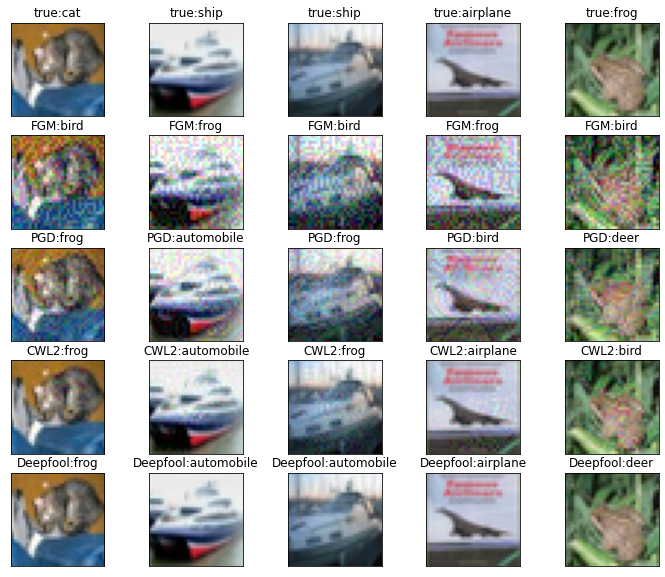

In [20]:
#Show five original samples and their corresponding adversarial samples
n = 5  # how many digits we will display
plt.figure(figsize=(12, 10))
for i in range(n):
    # display original samples 
    ax = plt.subplot(5, n, i+1)
    plt.imshow(testX[i])
    plt.imshow(testX[i])
    p=model.predict(np.array(testX[i]).reshape(1,32,32,3))    #绘制预测标签
    label = labels[np.argsort(p[0])[::-1][0]]
    true_label = labels[np.argsort(testY[i])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('true:'+str(true_label))

    # display FGM asversarial sample 
    ax = plt.subplot(5, n, i + 1+ n)
    plt.imshow(fgm_attack_data[i])
    p = model.predict(np.array(fgm_attack_data[i]).reshape(1,32,32,3))    #绘制预测标签
    label = labels[np.argsort(p[0])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('FGM:'+str(label))
    
    # display PGD asversarial sample 
    ax = plt.subplot(5, n, i + 1 + n*2)
    plt.imshow(pgd_attack_data[i])
    p=model.predict(np.array(pgd_attack_data[i]).reshape(1,32,32,3))    #绘制预测标签
    label =labels[np.argsort(p[0])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('PGD:'+str(label))

    # display CarliniWagnerL2Attack asversarial sample 
    ax = plt.subplot(5, n, i + 1 + n*3)
    plt.imshow(cw_attack_data[i])
    p=model.predict(np.array(cw_attack_data[i]).reshape(1,32,32,3))    #绘制预测标签
    label =labels[np.argsort(p[0])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('CWL2:'+str(label))

    # display Deepfool asversarial sample 
    ax = plt.subplot(5, n, i + 1 + n*4)
    plt.imshow(df_attack_data[i])
    p=model.predict(np.array(df_attack_data[i]).reshape(1,32,32,3))    #绘制预测标签
    label =labels[np.argsort(p[0])[::-1][0]]
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.title.set_text('Deepfool:'+str(label))
plt.show()

In [21]:
#Implementing the adversarial training defense

# Generate adversarial examples on training data
fgm_attack_data_train = np.zeros([50000,32,32,3])
for i in range(10):
  print(i)
  fgm_attack_data_train[i*5000:(i+1)*5000] = fgm.generate_np(trainX[i*5000:(i+1)*5000], **fgm_params)

# create new data set consisting of original and adversarial samples with corrected labels
data_total_train = np.concatenate([trainX, fgm_attack_data_train])
labels_total_train = np.concatenate([trainY, trainY])



0
1
2
3
4
5
6
7
8
9


In [22]:
# re-train classifier on corrected data (without overwriting original classifier graph)
fgm_adv_train_clf = define_model()
fgm_adv_train_clf.set_weights(model.get_weights()) 
fgm_adv_train_clf.fit(data_total_train, labels_total_train, validation_data=(fgm_attack_data, testY), epochs=100, batch_size=250, shuffle=True)
fgm_adv_train_clf.save('./drive/My Drive/model_store/crf10fgm.hdf5')


Train on 100000 samples, validate on 10000 samples
Epoch 1/100
100000/100000 [==============================] - 16s 160us/step - loss: 1.4318 - accuracy: 0.5043 - val_loss: 1.8563 - val_accuracy: 0.2532
Epoch 2/100
100000/100000 [==============================] - 14s 145us/step - loss: 1.1856 - accuracy: 0.5454 - val_loss: 1.7330 - val_accuracy: 0.3140
Epoch 3/100
100000/100000 [==============================] - 14s 144us/step - loss: 1.1268 - accuracy: 0.5688 - val_loss: 1.6526 - val_accuracy: 0.3632
Epoch 4/100
100000/100000 [==============================] - 14s 144us/step - loss: 1.0874 - accuracy: 0.5881 - val_loss: 1.5922 - val_accuracy: 0.3985
Epoch 5/100
100000/100000 [==============================] - 14s 144us/step - loss: 1.0542 - accuracy: 0.6042 - val_loss: 1.5370 - val_accuracy: 0.4214
Epoch 6/100
100000/100000 [==============================] - 14s 144us/step - loss: 1.0281 - accuracy: 0.6179 - val_loss: 1.4899 - val_accuracy: 0.4458
Epoch 7/100
100000/100000 [=========

In [23]:
fgm_adv_clf = define_model()
fgm_adv_clf.set_weights(fgm_adv_train_clf.get_weights()) 
fgm_adv_clf.fit(data_total_train, labels_total_train, validation_data=(fgm_attack_data, testY), epochs=100, batch_size=250, shuffle=True)
#fgm_adv_clf.save('./drive/My Drive/model_store/crf10fgm.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 1/100
100000/100000 [==============================] - 15s 154us/step - loss: 0.4838 - accuracy: 0.8422 - val_loss: 0.7128 - val_accuracy: 0.7932
Epoch 2/100
100000/100000 [==============================] - 14s 143us/step - loss: 0.4798 - accuracy: 0.8452 - val_loss: 0.7093 - val_accuracy: 0.7958
Epoch 3/100
100000/100000 [==============================] - 14s 143us/step - loss: 0.4800 - accuracy: 0.8439 - val_loss: 0.7109 - val_accuracy: 0.7955
Epoch 4/100
100000/100000 [==============================] - 14s 144us/step - loss: 0.4775 - accuracy: 0.8435 - val_loss: 0.7112 - val_accuracy: 0.7951
Epoch 5/100
100000/100000 [==============================] - 14s 142us/step - loss: 0.4752 - accuracy: 0.8449 - val_loss: 0.7162 - val_accuracy: 0.7936
Epoch 6/100
100000/100000 [==============================] - 14s 144us/step - loss: 0.4718 - accuracy: 0.8470 - val_loss: 0.7067 - val_accuracy: 0.7941
Epoch 7/100
100000/100000 [==========

In [25]:
fgm_adv_clf.save('./drive/My Drive/model_store/crf10fgm.hdf5')

In [18]:
fgm_adv_clf = keras.models.load_model('./drive/My Drive/model_store/crf10fgm.hdf5')

In [26]:
#Implementing the adversarial training defense

# Generate adversarial examples on training data
pgd_params = {'eps':0.1, 'eps_iter':0.01, 'nb_iter':20, 'clip_min': 0., 'clip_max': 1.}
pgd_attack_data_train = np.zeros([50000,32,32,3])
for i in range(10):
  print(i)
  pgd_attack_data_train[i*5000:(i+1)*5000] = pgd.generate_np(trainX[i*5000:(i+1)*5000], **pgd_params)

# create new data set consisting of original and adversarial samples with corrected labels
data_total_train = np.concatenate([trainX, pgd_attack_data_train])
labels_total_train = np.concatenate([trainY, trainY])



0
1
2
3
4
5
6
7
8
9


In [27]:
# re-train classifier on corrected data (without overwriting original classifier graph)
adv_train_clf = define_model()
adv_train_clf.set_weights(model.get_weights()) 
adv_train_clf.fit(data_total_train, labels_total_train, validation_data=(pgd_attack_data, testY), epochs=200, batch_size=250, shuffle=True)
adv_train_clf.save('./drive/My Drive/model_store/crf10pgd.hdf5')

Train on 100000 samples, validate on 10000 samples
Epoch 1/200
100000/100000 [==============================] - 16s 160us/step - loss: 1.6225 - accuracy: 0.5617 - val_loss: 1.2269 - val_accuracy: 0.5543
Epoch 2/200
100000/100000 [==============================] - 14s 142us/step - loss: 0.9387 - accuracy: 0.6716 - val_loss: 0.9944 - val_accuracy: 0.6342
Epoch 3/200
100000/100000 [==============================] - 14s 142us/step - loss: 0.8299 - accuracy: 0.7096 - val_loss: 0.8898 - val_accuracy: 0.6783
Epoch 4/200
100000/100000 [==============================] - 14s 143us/step - loss: 0.7702 - accuracy: 0.7307 - val_loss: 0.8302 - val_accuracy: 0.7033
Epoch 5/200
100000/100000 [==============================] - 14s 143us/step - loss: 0.7333 - accuracy: 0.7430 - val_loss: 0.7934 - val_accuracy: 0.7161
Epoch 6/200
100000/100000 [==============================] - 14s 143us/step - loss: 0.7052 - accuracy: 0.7538 - val_loss: 0.7601 - val_accuracy: 0.7272
Epoch 7/200
100000/100000 [==========

In [29]:
#Using the defense

# evaluate accuracy on adv trained classifier
adv_trained_scores = adv_train_clf.evaluate(testX, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = adv_train_clf.evaluate(pgd_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))

10000/10000 [==============================] - 1s 138us/step
Adversarially Trained Classifier Accuracy: 85.63%
10000/10000 [==============================] - 1s 126us/step
Adversarially Trained Classifier Accuracy: 83.02%


In [20]:
#Evaluate accuracy on target classifier
fgm_adv_scores = model.evaluate(fgm_attack_data, testY)
print("FGM Adversarial Attak Accuracy: %.2f%%" %(fgm_adv_scores[1]*100))
pgd_scores = model.evaluate(pgd_attack_data, testY)
print("PGD Adversarial Attack Accuracy: %.2f%%" %(pgd_scores[1]*100))
cw_scores = model.evaluate(cw_attack_data, testY)
print("Carlini & Wagner Adversarial Attack Accuracy: %.2f%%" %(cw_scores[1]*100))
df_scores = model.evaluate(df_attack_data, testY)
print("DeepFool Adversarial Attack Accuracy: %.2f%%" %(df_scores[1]*100))

10000/10000 [==============================] - 1s 133us/step
FGM Adversarial Attak Accuracy: 8.22%
10000/10000 [==============================] - 1s 122us/step
PGD Adversarial Attack Accuracy: 2.38%
10000/10000 [==============================] - 1s 114us/step
Carlini & Wagner Adversarial Attack Accuracy: 5.39%
10000/10000 [==============================] - 1s 120us/step
DeepFool Adversarial Attack Accuracy: 8.05%


In [21]:
#FGSM trained model for 4 attacks

# evaluate accuracy on adv trained classifier
adv_trained_scores = fgm_adv_clf.evaluate(testX, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = fgm_adv_clf.evaluate(fgm_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = fgm_adv_clf.evaluate(pgd_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = fgm_adv_clf.evaluate(cw_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = fgm_adv_clf.evaluate(df_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))


10000/10000 [==============================] - 2s 164us/step
Adversarially Trained Classifier Accuracy: 87.07%
10000/10000 [==============================] - 1s 126us/step
Adversarially Trained Classifier Accuracy: 81.89%
10000/10000 [==============================] - 1s 124us/step
Adversarially Trained Classifier Accuracy: 39.11%
10000/10000 [==============================] - 1s 119us/step
Adversarially Trained Classifier Accuracy: 78.01%
10000/10000 [==============================] - 1s 123us/step
Adversarially Trained Classifier Accuracy: 85.52%


In [22]:
#PGD trained model for 4 attacks

# evaluate accuracy on adv trained classifier
adv_trained_scores = adv_train_clf.evaluate(testX, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = adv_train_clf.evaluate(fgm_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = adv_train_clf.evaluate(pgd_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = adv_train_clf.evaluate(cw_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))
adv_trained_scores = adv_train_clf.evaluate(df_attack_data, testY)
print("Adversarially Trained Classifier Accuracy: %.2f%%" %(adv_trained_scores[1]*100))


10000/10000 [==============================] - 2s 166us/step
Adversarially Trained Classifier Accuracy: 85.63%
10000/10000 [==============================] - 1s 122us/step
Adversarially Trained Classifier Accuracy: 60.48%
10000/10000 [==============================] - 1s 122us/step
Adversarially Trained Classifier Accuracy: 83.32%
10000/10000 [==============================] - 1s 115us/step
Adversarially Trained Classifier Accuracy: 85.06%
10000/10000 [==============================] - 1s 118us/step
Adversarially Trained Classifier Accuracy: 85.49%


In [23]:
import PIL
import PIL.Image
from io import BytesIO
def defend_jpeg(input_array,qty):
    pil_image = PIL.Image.fromarray((input_array*255.0).astype(np.uint8))
    f = BytesIO()
    pil_image.save(f, format='jpeg', quality=qty) # quality level specified in paper
    jpeg_image = np.asarray(PIL.Image.open(f)).astype(np.float32)/255.0
    return jpeg_image

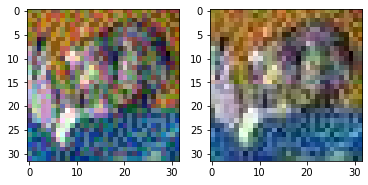

In [34]:
test = fgm_attack_data[0]
plt.subplot(1,2,1)
plt.imshow(test)
plt.subplot(1,2,2)
plt.imshow(defend_jpeg(test,75))

In [24]:
def jpg_compression(qty):
  org_defend = np.zeros([10000,32,32,3])
  for i in range(len(testX)):
    test = testX[i]
    jpeg = defend_jpeg(test,qty)
    org_defend[i] = jpeg

  fgm_defend = np.zeros([10000,32,32,3])
  for i in range(len(testX)):
    test = fgm_attack_data[i]
    jpeg = defend_jpeg(test,qty)
    fgm_defend[i] = jpeg

  pgd_defend = np.zeros([10000,32,32,3])
  for i in range(len(testX)):
    test = pgd_attack_data[i]
    jpeg = defend_jpeg(test,qty)
    pgd_defend[i] = jpeg

  cw_defend = np.zeros([10000,32,32,3])
  for i in range(len(testX)):
    test = cw_attack_data[i]
    jpeg = defend_jpeg(test,qty)
    cw_defend[i] = jpeg

  df_defend = np.zeros([10000,32,32,3])
  for i in range(len(testX)):
    test = df_attack_data[i]
    jpeg = defend_jpeg(test,qty)
    df_defend[i] = jpeg
  return org_defend,fgm_defend,pgd_defend,cw_defend,df_defend

In [25]:
def jpeg_score(qty):
  org_defend,fgm_defend,pgd_defend,cw_defend,df_defend = jpg_compression(qty)
  org_score = model.evaluate(org_defend, testY)
  org_score = org_score[1]
  fgm_score = model.evaluate(fgm_defend, testY)
  fgm_score = fgm_score[1]
  pgd_score = model.evaluate(pgd_defend, testY)
  pgd_score = pgd_score[1]
  cw_score = model.evaluate(cw_defend, testY)
  cw_score = cw_score[1]
  df_score = model.evaluate(df_defend, testY)
  df_score = df_score[1]
  return org_score,fgm_score,pgd_score,cw_score,df_score

In [26]:
jpeg_score(90)

10000/10000 [==============================] - 1s 122us/step


(0.8118000030517578,
 0.08089999854564667,
 0.026399999856948853,
 0.40790000557899475,
 0.7652999758720398)

In [27]:
q_list = []
o_list = []
f_list = []
p_list = []
c_list = []
d_list = []
for q in range(1,20):
  print(q)
  qty = q*5
  o,f,p,c,d=jpeg_score(qty)
  q_list.append(qty)
  o_list.append(o)
  f_list.append(f)
  p_list.append(p)
  c_list.append(c)r4rrm
  d_list.append(d)

1
10000/10000 [==============================] - 1s 122us/step
2
10000/10000 [==============================] - 1s 121us/step
3
10000/10000 [==============================] - 1s 124us/step
4
10000/10000 [==============================] - 1s 119us/step
5
10000/10000 [==============================] - 1s 120us/step
6
10000/10000 [==============================] - 1s 119us/step
7
10000/10000 [==============================] - 1s 122us/step
8
10000/10000 [==============================] - 1s 122us/step
9
10000/10000 [==============================] - 1s 118us/step
10
10000/10000 [==============================] - 1s 124us/step
11
10000/10000 [==============================] - 1s 122us/step
12
10000/10000 [==============================] - 1s 121us/step
13
10000/10000 [==============================] - 1s 122us/step
14
10000/10000 [==============================] - 1s 122us/step
15
10000/10000 [==============================] - 1s 121us/step
16
10000/10000 [==============================] -

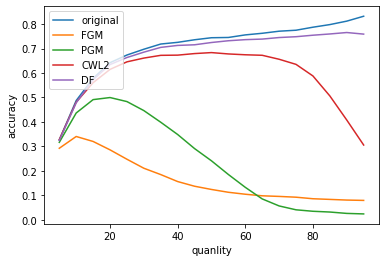

In [28]:
plt.plot(q_list,o_list)
plt.plot(q_list,f_list)
plt.plot(q_list,p_list)
plt.plot(q_list,c_list)
plt.plot(q_list,d_list)
plt.ylabel('accuracy')
plt.xlabel('quanlity')
plt.legend(['original','FGM', 'PGM','CWL2','DF'], loc='upper left')
plt.show()

In [30]:
org_defend,fgm_defend,pgd_defend,cw_defend,df_defend=jpg_compression(80)
# JPEG Compression Defense
org_defense_scores = model.evaluate(org_defend, testY)
print("ORG Adversarial Denfense Accuracy: %.2f%%" %(org_defense_scores[1]*100))
fgm_defense_scores = model.evaluate(fgm_defend, testY)
print("FGM Adversarial Denfense Accuracy: %.2f%%" %(fgm_defense_scores[1]*100))
pgd_defense_scores = model.evaluate(pgd_defend, testY)
print("PGD Adversarial Denfense Accuracy: %.2f%%" %(pgd_defense_scores[1]*100))
cw_defense_scores = model.evaluate(cw_defend, testY)
print("CW Adversarial Denfense Accuracy: %.2f%%" %(cw_defense_scores[1]*100))
df_defense_scores = model.evaluate(df_defend, testY)
print("DF Adversarial Denfense Accuracy: %.2f%%" %(df_defense_scores[1]*100))


10000/10000 [==============================] - 1s 140us/step
ORG Adversarial Denfense Accuracy: 78.70%
10000/10000 [==============================] - 1s 132us/step
FGM Adversarial Denfense Accuracy: 8.63%
10000/10000 [==============================] - 1s 135us/step
PGD Adversarial Denfense Accuracy: 3.51%
10000/10000 [==============================] - 1s 132us/step
CW Adversarial Denfense Accuracy: 58.79%
10000/10000 [==============================] - 1s 133us/step
DF Adversarial Denfense Accuracy: 75.43%


In [33]:
# pgd Adversial Training Defense
fgm_trained_scores = adv_train_clf.evaluate(fgm_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on FGM: %.2f%%" %(fgm_trained_scores[1]*100))
pgd_trained_scores = adv_train_clf.evaluate(pgd_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on PGD: %.2f%%" %(pgd_trained_scores[1]*100))
cw_trained_scores = adv_train_clf.evaluate(cw_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on CW: %.2f%%" %(cw_trained_scores[1]*100))
fl_trained_scores = adv_train_clf.evaluate(df_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on FL: %.2f%%" %(fl_trained_scores[1]*100))
# pgd Adversial Training Defense + jpeg compression
org_trained_scores = adv_train_clf.evaluate(org_defend, testY)
print("Adversarially Trained Classifier Accuracy on ORG: %.2f%%" %(org_trained_scores[1]*100))
fgm_trained_scores = adv_train_clf.evaluate(fgm_defend, testY)
print("Adversarially Trained Classifier Accuracy on FGM: %.2f%%" %(fgm_trained_scores[1]*100))
pgd_trained_scores = adv_train_clf.evaluate(pgd_defend, testY)
print("Adversarially Trained Classifier Accuracy on PGD: %.2f%%" %(pgd_trained_scores[1]*100))
cw_trained_scores = adv_train_clf.evaluate(cw_defend, testY)
print("Adversarially Trained Classifier Accuracy on CW: %.2f%%" %(cw_trained_scores[1]*100))
fl_trained_scores = adv_train_clf.evaluate(df_defend, testY)
print("Adversarially Trained Classifier Accuracy on FL: %.2f%%" %(fl_trained_scores[1]*100))
# fgm Adversial Training Defense
fgm_trained_scores = fgm_adv_clf.evaluate(fgm_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on FGM: %.2f%%" %(fgm_trained_scores[1]*100))
pgd_trained_scores = fgm_adv_clf.evaluate(pgd_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on PGD: %.2f%%" %(pgd_trained_scores[1]*100))
cw_trained_scores = fgm_adv_clf.evaluate(cw_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on CW: %.2f%%" %(cw_trained_scores[1]*100))
fl_trained_scores = fgm_adv_clf.evaluate(df_attack_data, testY)
print("Adversarially Trained Classifier Accuracy on FL: %.2f%%" %(fl_trained_scores[1]*100))
# fgm Adversial Training Defense + jpeg compression
org_trained_scores = fgm_adv_clf.evaluate(org_defend, testY)
print("Adversarially Trained Classifier Accuracy on ORG: %.2f%%" %(org_trained_scores[1]*100))
fgm_trained_scores = fgm_adv_clf.evaluate(fgm_defend, testY)
print("Adversarially Trained Classifier Accuracy on FGM: %.2f%%" %(fgm_trained_scores[1]*100))
pgd_trained_scores = fgm_adv_clf.evaluate(pgd_defend, testY)
print("Adversarially Trained Classifier Accuracy on PGD: %.2f%%" %(pgd_trained_scores[1]*100))
cw_trained_scores = fgm_adv_clf.evaluate(cw_defend, testY)
print("Adversarially Trained Classifier Accuracy on CW: %.2f%%" %(cw_trained_scores[1]*100))
fl_trained_scores = fgm_adv_clf.evaluate(df_defend, testY)
print("Adversarially Trained Classifier Accuracy on FL: %.2f%%" %(fl_trained_scores[1]*100))

10000/10000 [==============================] - 1s 133us/step
Adversarially Trained Classifier Accuracy on FGM: 60.48%
10000/10000 [==============================] - 1s 123us/step
Adversarially Trained Classifier Accuracy on PGD: 83.32%
10000/10000 [==============================] - 1s 115us/step
Adversarially Trained Classifier Accuracy on CW: 85.06%
10000/10000 [==============================] - 1s 120us/step
Adversarially Trained Classifier Accuracy on FL: 85.49%
10000/10000 [==============================] - 1s 120us/step
Adversarially Trained Classifier Accuracy on ORG: 84.29%
10000/10000 [==============================] - 1s 122us/step
Adversarially Trained Classifier Accuracy on FGM: 48.66%
10000/10000 [==============================] - 1s 121us/step
Adversarially Trained Classifier Accuracy on PGD: 74.39%
10000/10000 [==============================] - 1s 123us/step
Adversarially Trained Classifier Accuracy on CW: 83.13%
10000/10000 [==============================] - 1s 121us/ste

In [34]:
PAD_VALUE = 0
def defend(input_tensor):
    n = input_tensor.shape[0]
    rnd = tf.random_uniform((), 32, 35, dtype=tf.int32)
    rescaled = tf.image.crop_and_resize(input_tensor, [[0, 0, 1, 1] for i in range(n)], [i for i in range(n)], [rnd, rnd])
    # print(input_tensor.shape)
    h_rem = 35 - rnd
    w_rem = 35 - rnd
    pad_left = tf.random_uniform((), 0, w_rem, dtype=tf.int32)
    pad_right = w_rem - pad_left
    pad_top = tf.random_uniform((), 0, h_rem, dtype=tf.int32)
    pad_bottom = h_rem - pad_top
    padded = tf.pad(rescaled, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], constant_values=PAD_VALUE)
    padded.set_shape((n, 35, 35, 3))
    return padded
def random_defense(image):
    n = image.shape[0]
    input_tensor = image.reshape(n,32,32,3)
    defense_img = defend(input_tensor)
    defense_img = sess.run(defense_img)
    retest = tf.image.resize_images(defense_img, [32,32], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    retest = sess.run(retest)
    #retest = np.array(retest).reshape(n,28*28)
    return retest

Instructions for updating:
box_ind is deprecated, use box_indices instead


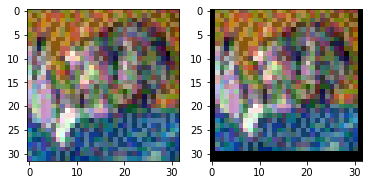

In [35]:
test = fgm_attack_data[0].reshape(1,32,32,3)
plt.subplot(1,2,1)
plt.imshow(test.reshape(32,32,3))
plt.subplot(1,2,2)
plt.imshow(random_defense(test).reshape(32,32,3))

In [36]:
fgm_rand_defend = np.zeros((1000,32,32,3))
for i in range(100):
    if i % 10 == 0:
      print(i)
    test = fgm_attack_data[i*10:(i+1)*10]
    randimg = random_defense(test)
    fgm_rand_defend[i*10:(i+1)*10]=randimg

0
10
20
30
40
50
60
70
80
90


In [37]:
fgm_trained_scores = model.evaluate(fgm_rand_defend, testY[:1000])
print("Original Classifier Accuracy on FGM random defense: %.2f%%" %(fgm_trained_scores[1]*100))
fgm_trained_scores = adv_train_clf.evaluate(fgm_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on FGM random defense: %.2f%%" %(fgm_trained_scores[1]*100))

1000/1000 [==============================] - 0s 289us/step
Original Classifier Accuracy on FGM random defense: 10.70%
1000/1000 [==============================] - 0s 126us/step
Adversarially Trained Classifier Accuracy on FGM random defense: 59.20%


In [38]:
pgd_rand_defend = np.zeros((1000,32,32,3))
for i in range(100):
    if i % 10 == 0:
      print(i)
    test = pgd_attack_data[i*10:(i+1)*10]
    randimg = random_defense(test)
    pgd_rand_defend[i*10:(i+1)*10]=randimg


0
10
20
30
40
50
60
70
80
90


In [39]:
pgd_trained_scores = model.evaluate(pgd_rand_defend, testY[:1000])
print("Original Classifier Accuracy on PGD random defense: %.2f%%" %(pgd_trained_scores[1]*100))
pgd_trained_scores = adv_train_clf.evaluate(pgd_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on PGD random defense: %.2f%%" %(pgd_trained_scores[1]*100))

1000/1000 [==============================] - 0s 203us/step
Original Classifier Accuracy on PGD random defense: 1.90%
1000/1000 [==============================] - 0s 179us/step
Adversarially Trained Classifier Accuracy on PGD random defense: 78.60%


In [40]:
cw_rand_defend = np.zeros((1000,32,32,3))
for i in range(100):
    if i % 10 == 0:
      print(i)
    test = cw_attack_data[i*10:(i+1)*10]
    randimg = random_defense(test)
    cw_rand_defend[i*10:(i+1)*10]=randimg

0
10
20
30
40
50
60
70
80
90


In [41]:
cw_trained_scores = model.evaluate(cw_rand_defend, testY[:1000])
print("Original Classifier Accuracy on CW random defense: %.2f%%" %(cw_trained_scores[1]*100))
cw_trained_scores = adv_train_clf.evaluate(cw_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on CW random defense: %.2f%%" %(cw_trained_scores[1]*100))


1000/1000 [==============================] - 0s 174us/step
Original Classifier Accuracy on CW random defense: 52.90%
1000/1000 [==============================] - 0s 165us/step
Adversarially Trained Classifier Accuracy on CW random defense: 80.90%


In [42]:
df_rand_defend = np.zeros((1000,32,32,3))
for i in range(100):
    if i % 10 == 0:
      print(i)
    test = df_attack_data[i*10:(i+1)*10]
    randimg = random_defense(test)
    df_rand_defend[i*10:(i+1)*10]=randimg
df_trained_scores = model.evaluate(df_rand_defend, testY[:1000])
print("Original Classifier Accuracy on DF random defense: %.2f%%" %(df_trained_scores[1]*100))
df_trained_scores = adv_train_clf.evaluate(df_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on DF random defense: %.2f%%" %(df_trained_scores[1]*100))


0
10
20
30
40
50
60
70
80
90
1000/1000 [==============================] - 0s 168us/step
Original Classifier Accuracy on DF random defense: 74.90%
1000/1000 [==============================] - 0s 151us/step
Adversarially Trained Classifier Accuracy on DF random defense: 82.10%


In [67]:
org_rand_defend = np.zeros((1000,32,32,3))
for i in range(100):
    if i % 10 == 0:
      print(i)
    test = testX[i*10:(i+1)*10]
    randimg = random_defense(test)
    org_rand_defend[i*10:(i+1)*10]=randimg
org_trained_scores = model.evaluate(org_rand_defend, testY[:1000])
print("Original Classifier Accuracy on org random defense: %.2f%%" %(df_trained_scores[1]*100))
org_trained_scores = adv_train_clf.evaluate(org_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on org random defense: %.2f%%" %(df_trained_scores[1]*100))


0
10
20
30
40
50
60
70
80
90
1000/1000 [==============================] - 0s 160us/step
Original Classifier Accuracy on org random defense: 82.10%
1000/1000 [==============================] - 0s 159us/step
Adversarially Trained Classifier Accuracy on org random defense: 82.10%


In [68]:
# Random Resize and Padding
org_trained_scores = model.evaluate(org_rand_defend, testY[:1000])
print("Original Classifier Accuracy on org random defense: %.2f%%" %(df_trained_scores[1]*100))
fgm_trained_scores = model.evaluate(fgm_rand_defend, testY[:1000])
print("Original Classifier Accuracy on FGM random defense: %.2f%%" %(fgm_trained_scores[1]*100))
pgd_trained_scores = model.evaluate(pgd_rand_defend, testY[:1000])
print("Original Classifier Accuracy on PGD random defense: %.2f%%" %(pgd_trained_scores[1]*100))
cw_trained_scores = model.evaluate(cw_rand_defend, testY[:1000])
print("Original Classifier Accuracy on CW random defense: %.2f%%" %(cw_trained_scores[1]*100))
df_trained_scores = model.evaluate(df_rand_defend, testY[:1000])
print("Original Classifier Accuracy on DF random defense: %.2f%%" %(df_trained_scores[1]*100))
# Adversial Training Defense + Random Resize and Padding
org_trained_scores = adv_train_clf.evaluate(org_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on org random defense: %.2f%%" %(df_trained_scores[1]*100))
fgm_trained_scores = adv_train_clf.evaluate(fgm_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on FGM random defense: %.2f%%" %(fgm_trained_scores[1]*100))
pgd_trained_scores = adv_train_clf.evaluate(pgd_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on PGD random defense: %.2f%%" %(pgd_trained_scores[1]*100))
cw_trained_scores = adv_train_clf.evaluate(cw_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on CW random defense: %.2f%%" %(cw_trained_scores[1]*100))
df_trained_scores = adv_train_clf.evaluate(df_rand_defend, testY[:1000])
print("Adversarially Trained Classifier Accuracy on DF random defense: %.2f%%" %(df_trained_scores[1]*100))


1000/1000 [==============================] - 0s 161us/step
Original Classifier Accuracy on org random defense: 82.10%
1000/1000 [==============================] - 0s 160us/step
Original Classifier Accuracy on FGM random defense: 10.70%
1000/1000 [==============================] - 0s 155us/step
Original Classifier Accuracy on PGD random defense: 1.90%
1000/1000 [==============================] - 0s 158us/step
Original Classifier Accuracy on CW random defense: 52.90%
1000/1000 [==============================] - 0s 154us/step
Original Classifier Accuracy on DF random defense: 74.90%
1000/1000 [==============================] - 0s 150us/step
Adversarially Trained Classifier Accuracy on org random defense: 74.90%
1000/1000 [==============================] - 0s 168us/step
Adversarially Trained Classifier Accuracy on FGM random defense: 59.20%
1000/1000 [==============================] - 0s 159us/step
Adversarially Trained Classifier Accuracy on PGD random defense: 78.60%
1000/1000 [=========

In [52]:
#Calculate PCA projection
pca = PCA(600)

pca.fit(trainX.reshape(50000,3072))
pca_train = pca.transform(trainX.reshape(50000,3072))
pca_test = pca.transform(testX.reshape(10000,3072))

In [69]:
def pca_model():
    model = Sequential()
    model.add(Dense(600, activation='relu', kernel_initializer="normal", input_dim=600))
    model.add(Dropout(0.2))
    model.add(Dense(300, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    model.add(Dense(100, activation='relu', kernel_initializer='normal'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax', kernel_initializer='normal'))
    return model
pca_clf = pca_model()
pca_clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
pca_clf.fit(pca_train, trainY, validation_data=(pca_test, testY), epochs=50, batch_size=256, shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 68us/step - loss: 1.8551 - accuracy: 0.3309 - val_loss: 1.5653 - val_accuracy: 0.4519
Epoch 2/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.5827 - accuracy: 0.4374 - val_loss: 1.4201 - val_accuracy: 0.4972
Epoch 3/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.4443 - accuracy: 0.4873 - val_loss: 1.3579 - val_accuracy: 0.5211
Epoch 4/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.3367 - accuracy: 0.5272 - val_loss: 1.3139 - val_accuracy: 0.5296
Epoch 5/50
50000/50000 [==============================] - 2s 30us/step - loss: 1.2473 - accuracy: 0.5628 - val_loss: 1.2943 - val_accuracy: 0.5357
Epoch 6/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.1633 - accuracy: 0.5876 - val_loss: 1.2739 - val_accuracy: 0.5482
Epoch 7/50
50000/50000 [==============================] - 2s 30us/st

In [73]:
pca_fgm_test = pca.transform(fgm_attack_data.reshape(10000,3072))
pca_pgd_test = pca.transform(pgd_attack_data.reshape(10000,3072))
pca_cw_test = pca.transform(cw_attack_data.reshape(10000,3072))
pca_df_test = pca.transform(df_attack_data.reshape(10000,3072))
pca_adv_acc = pca_clf.evaluate(pca_test, testY)
print ("PCA Classifier Accuracy on org attacked data: %.2f%%" %(pca_adv_acc[1]*100))


pca_adv_acc = pca_clf.evaluate(pca_fgm_test, testY)
print ("PCA Classifier Accuracy on FGM attacked data: %.2f%%" %(pca_adv_acc[1]*100))

pca_adv_acc = pca_clf.evaluate(pca_pgd_test, testY)
print ("PCA Classifier Accuracy on PGD attacked data: %.2f%%" %(pca_adv_acc[1]*100))

pca_adv_acc = pca_clf.evaluate(pca_cw_test, testY)
print ("PCA Classifier Accuracy on CW attacked data: %.2f%%" %(pca_adv_acc[1]*100))

pca_adv_acc = pca_clf.evaluate(pca_df_test, testY)
print ("PCA Classifier Accuracy on DF attacked data: %.2f%%" %(pca_adv_acc[1]*100))

10000/10000 [==============================] - 1s 81us/step
PCA Classifier Accuracy on org attacked data: 54.41%
10000/10000 [==============================] - 1s 78us/step
PCA Classifier Accuracy on FGM attacked data: 45.29%
10000/10000 [==============================] - 1s 78us/step
PCA Classifier Accuracy on PGD attacked data: 49.69%
10000/10000 [==============================] - 1s 77us/step
PCA Classifier Accuracy on CW attacked data: 53.79%
10000/10000 [==============================] - 1s 78us/step
PCA Classifier Accuracy on DF attacked data: 54.18%


In [72]:
pca_fgm_defend = pca.transform(fgm_defend.reshape(10000,3072))
pca_pgd_defend = pca.transform(pgd_defend.reshape(10000,3072))
pca_cw_defend = pca.transform(cw_defend.reshape(10000,3072))
pca_df_defend = pca.transform(df_defend.reshape(10000,3072))
#Using the defense (and comparing to baseline accuracy)


pca_adv_acc = pca_clf.evaluate(pca_fgm_defend, testY)
print ("PCA Classifier Accuracy on FGM attacked data: %.2f%%" %(pca_adv_acc[1]*100))

pca_adv_acc = pca_clf.evaluate(pca_pgd_defend, testY)
print ("PCA Classifier Accuracy on PGD attacked data: %.2f%%" %(pca_adv_acc[1]*100))

pca_adv_acc = pca_clf.evaluate(pca_cw_defend, testY)
print ("PCA Classifier Accuracy on CW attacked data: %.2f%%" %(pca_adv_acc[1]*100))

pca_adv_acc = pca_clf.evaluate(pca_df_defend, testY)
print ("PCA Classifier Accuracy on DF attacked data: %.2f%%" %(pca_adv_acc[1]*100))

10000/10000 [==============================] - 1s 84us/step
PCA Classifier Accuracy on FGM attacked data: 44.52%
10000/10000 [==============================] - 1s 81us/step
PCA Classifier Accuracy on PGD attacked data: 48.43%
10000/10000 [==============================] - 1s 79us/step
PCA Classifier Accuracy on CW attacked data: 53.01%
10000/10000 [==============================] - 1s 79us/step
PCA Classifier Accuracy on DF attacked data: 54.10%
